# Load the observation data(Generated by the FDM Model)

File successfully loaded: fdm_observation_data.csv
Data shape: (100000, 7)

Column names:
['time_days', 'temperature_0m', 'temperature_1m', 'temperature_2m', 'temperature_3m', 'temperature_4m', 'temperature_5m']


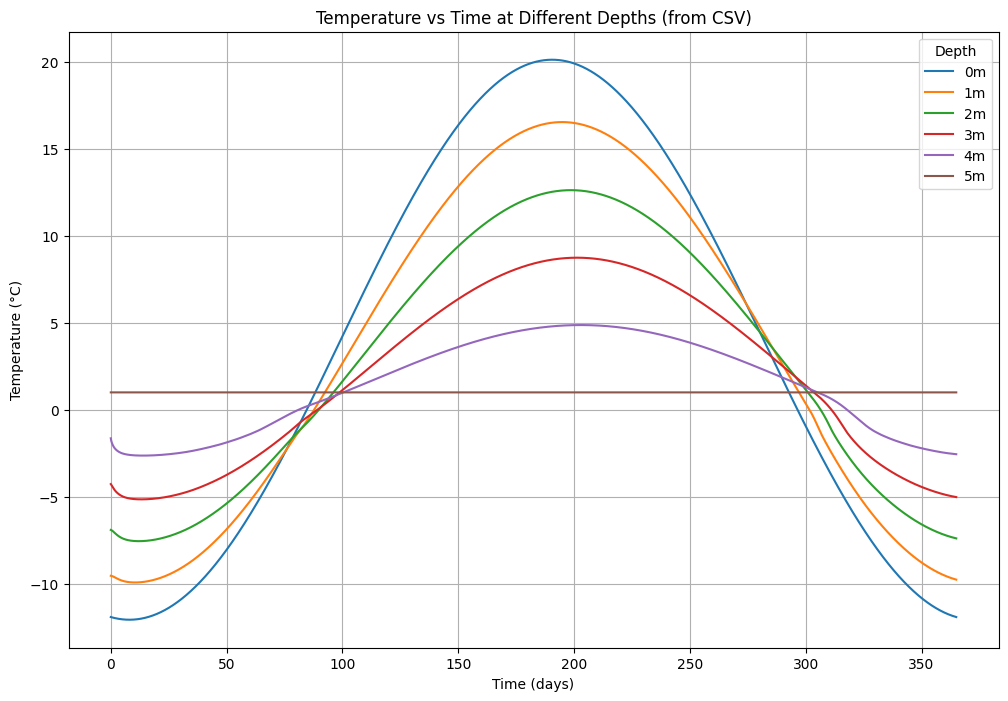


First 5 rows:
   time_days  temperature_0m  temperature_1m  temperature_2m  temperature_3m  \
0    0.00000      -11.926392       -9.552234       -6.914287       -4.276604   
1    0.00365      -11.926532       -9.552312       -6.914457       -4.277133   
2    0.00730      -11.926671       -9.552390       -6.914628       -4.277667   
3    0.01095      -11.926810       -9.552468       -6.914799       -4.278204   
4    0.01460      -11.926949       -9.552546       -6.914971       -4.278746   

   temperature_4m  temperature_5m  
0       -1.641872             1.0  
1       -1.645727             1.0  
2       -1.649533             1.0  
3       -1.653264             1.0  
4       -1.656913             1.0  

Statistical summary:
           time_days  temperature_0m  temperature_1m  temperature_2m  \
count  100000.000000   100000.000000   100000.000000   100000.000000   
mean      182.500000        4.030000        3.370696        2.655721   
std       105.368005       11.391547        9.3692

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file
filename = 'fdm_observation_data.csv'
df = pd.read_csv(filename)

# Print basic information
print("File successfully loaded:", filename)
print(f"Data shape: {df.shape}")
print("\nColumn names:")
print(df.columns.tolist())

# Plot temperature vs. time
plt.figure(figsize=(12, 8))

# Find all temperature columns (those containing "temperature")
temp_columns = [col for col in df.columns if 'temperature' in col]

# Plot each column
for col in temp_columns:
    depth = col.split('_')[1]  # extract depth label (e.g., "1m")
    plt.plot(df['time_days'], df[col], label=f'{depth}')

plt.xlabel('Time (days)')
plt.ylabel('Temperature (°C)')
plt.title('Temperature vs Time at Different Depths (from CSV)')
plt.legend(title='Depth')
plt.grid(True)
plt.show()

# Show first 5 rows of data
print("\nFirst 5 rows:")
print(df.head())

# Show statistical summary
print("\nStatistical summary:")
print(df.describe())


## PINNs Forward Modeling

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import random

# Set random seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(42)

# Neural network definition
class PhaseChangePINN(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.net = nn.Sequential()
        for i in range(len(layers)-1):
            self.net.add_module(f'linear_{i}', nn.Linear(layers[i], layers[i+1]))
            if i < len(layers)-2:
                self.net.add_module(f'tanh_{i}', nn.Tanh())
        # Parameter initialization
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.net(x)

# PINNs solver class
class FreezingSoilPINN:
    def __init__(self, params, device='cuda'):
        # Physical parameters
        self.device = device
        self.L = torch.tensor(params['L'], device=device)
        self.C_i = torch.tensor(params['C_i'], device=device)
        self.C_l = torch.tensor(params['C_l'], device=device)
        self.C_f = torch.tensor(params['C_f'], device=device)
        self.lambda_i = torch.tensor(params['lambda_i'], device=device)
        self.lambda_l = torch.tensor(params['lambda_l'], device=device)
        self.lambda_f = torch.tensor(params['lambda_f'], device=device)
        self.eta = torch.tensor(params['eta'], device=device)
        self.b = torch.tensor(params['b'], device=device)
        self.T_nabla = torch.tensor(params['T_nabla'], device=device)
        
        # Neural network
        self.model = PhaseChangePINN([2, 50, 50, 50, 1]).to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=1e-4)
        # self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, patience=500, factor=0.5)
        self.scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=1000)
        
        # Loss logs
        self.loss_history = []
        self.pde_loss = []
        self.bc0_loss = []
        self.bcL_loss = []
        self.ic_loss = []

    def _pore_water(self, T):
        """Pore water content calculation"""
        return torch.where(T >= self.T_nabla,
                          torch.ones_like(T),
                          torch.abs(self.T_nabla)**self.b * torch.abs(T)**(-self.b))

    def _unfrozen_water(self, T):
        """Unfrozen water content calculation"""
        return self.eta * self._pore_water(T)

    def _effective_heat_capacity(self, T):
        """Effective heat capacity calculation"""
        phi = self._pore_water(T)
        return (1-self.eta)*self.C_f + self.eta*(phi*self.C_l + (1-phi)*self.C_i)

    def _effective_conductivity(self, T):
        """Effective thermal conductivity calculation"""
        phi = self._pore_water(T)
        return (1-self.eta)*self.lambda_f + self.eta*(phi*self.lambda_l + (1-phi)*self.lambda_i)

    def _boundary_temp(self, t):
        """Upper boundary temperature function (x=0)"""
        return 4.03 + 16.11*torch.sin(2*np.pi*t/365 - 1.709)

    def _initial_temp(self, x):
        """Initial temperature field (t=0), linear interpolation"""
        z1, z2 = 0.0, 5.0 
        T1 = self._boundary_temp(torch.tensor(0.0)).item()  # Upper boundary temperature at t=0
        T2 = 1.0  # Lower boundary temperature
        return T1 + (T2 - T1)/(z2 - z1) * x


    def compute_loss(self, x, t):
        # Forward pass
        T_pred = self.model(torch.cat([x, t], dim=1))
        
        # Compute gradients
        dT_dt = torch.autograd.grad(T_pred, t, grad_outputs=torch.ones_like(T_pred), 
                                   create_graph=True, retain_graph=True)[0]
        dT_dx = torch.autograd.grad(T_pred, x, grad_outputs=torch.ones_like(T_pred),
                                   create_graph=True, retain_graph=True)[0]
        d2T_dx2 = torch.autograd.grad(dT_dx, x, grad_outputs=torch.ones_like(dT_dx),
                                     create_graph=True, retain_graph=True)[0]
        
        # Material property calculations
        C_eff = self._effective_heat_capacity(T_pred)
        lambda_eff = self._effective_conductivity(T_pred)
        theta = self._unfrozen_water(T_pred)
        dtheta_dt = torch.autograd.grad(theta, t, grad_outputs=torch.ones_like(theta),
                                       create_graph=True, retain_graph=True)[0]
        
        # PDE residual
        pde_res = C_eff*dT_dt - lambda_eff*d2T_dx2 - self.L*dtheta_dt
        pde_loss = torch.mean(pde_res**2)
        
        # Upper boundary condition (x=0)
        bc0_mask = (x == 0).squeeze()
        bc0_pred = T_pred[bc0_mask]
        bc0_true = self._boundary_temp(t[bc0_mask]) / self.T_max  # Scaled boundary condition
        bc0_loss = torch.mean((bc0_pred - bc0_true)**2)
        
        # Lower boundary condition (x=5)
        bcL_mask = (x == 5).squeeze()
        bcL_pred = T_pred[bcL_mask]
        bcL_true = torch.ones_like(bcL_pred) / self.T_max  # Scaled boundary condition
        bcL_loss = torch.mean((bcL_pred - bcL_true)**2)
        
        # Initial condition (t=0)
        ic_mask = (t == 0).squeeze()
        ic_pred = T_pred[ic_mask]
        ic_true = self._initial_temp(x[ic_mask]).unsqueeze(1) / self.T_max  # Scaled initial condition
        ic_loss = torch.mean((ic_pred - ic_true)**2)
        
        # Return total loss and component losses
        return 1e2*(pde_loss + bc0_loss + bcL_loss) + 1*ic_loss, pde_loss, bc0_loss, bcL_loss, ic_loss

    def train(self, x_domain, t_domain, epochs=20000, n_samples=10000):
        # Compute T_max (max of x=0 boundary data)
        t_test = torch.linspace(t_domain[0], t_domain[1], 1000, device=self.device)
        self.T_max = torch.max(self._boundary_temp(t_test)).item()
        print(f"T_max (scaling factor): {self.T_max}")
        
        # Generate training data
        x = torch.rand(n_samples, 1, device=self.device)*(x_domain[1]-x_domain[0]) + x_domain[0]
        t = torch.rand(n_samples, 1, device=self.device)*(t_domain[1]-t_domain[0]) + t_domain[0]
        x.requires_grad_(True)
        t.requires_grad_(True)
        
        # Add boundary points (enforced sampling)
        bc0_points = torch.zeros(500, 1, device=self.device)
        bc0_times = torch.rand(500, 1, device=self.device)*t_domain[1]
        bcL_points = torch.ones(500, 1, device=self.device)*5.0
        bcL_times = torch.rand(500, 1, device=self.device)*t_domain[1]
        ic_points = torch.rand(1000, 1, device=self.device) * 5.0  # Increased to 2000 points
        ic_times = torch.zeros(1000, 1, device=self.device)
        
        x = torch.cat([x, bc0_points, bcL_points, ic_points])
        t = torch.cat([t, bc0_times, bcL_times, ic_times])
    
            # Training loop
        for epoch in range(epochs):
            self.optimizer.zero_grad()
            
            # Compute loss
            total_loss, pde_loss, bc0_loss, bcL_loss, ic_loss = self.compute_loss(x, t)
            
            # Dynamically adjust IC weight
            if epoch < 10000:  # First 10000 epochs: focus on IC
                ic_weight = 1
            # elif epoch < 15000:  # Middle phase: gradually reduce IC weight
            #     ic_weight = 1e1
            else:  # Later phase: normal weight
                ic_weight = 1e3
                
            # Apply dynamic weight
            weighted_loss = 1e2*(pde_loss + bc0_loss + bcL_loss) + ic_weight*ic_loss
            weighted_loss.backward()
            
            self.optimizer.step()
            self.scheduler.step()
            
            # Log losses (using original values)
            self.loss_history.append(total_loss.item())
            self.pde_loss.append(pde_loss.item())
            self.bc0_loss.append(bc0_loss.item())
            self.bcL_loss.append(bcL_loss.item())
            self.ic_loss.append(ic_loss.item())
            
            # Print losses (using original values)
            if epoch % 1000 == 0:
                print(f'Epoch {epoch:5d}, Loss: {total_loss.item():.3e} | '
                      f'PDE: {pde_loss.item():.3e} | BC0: {bc0_loss.item():.3e} | '
                      f'BCL: {bcL_loss.item():.3e} | IC: {ic_loss.item():.3e}')
                
        return self.loss_history


    
    def predict(self, x, t):
        with torch.no_grad():
            xt = torch.cat([x, t], dim=1)
            return self.model(xt)

# Parameter configuration
params = {
    'L': 3.34e5,        # Latent heat of phase change (KJ/m³)
    'C_i': 1.672,       # Heat capacity of ice (KJ/(m³·K))
    'C_l': 4.18,        # Heat capacity of water (KJ/(m³·K))
    'C_f': 1.5,         # Heat capacity of soil matrix
    'lambda_i': 2.210,  # Thermal conductivity of ice (W/(m·K))
    'lambda_l': 0.465,  # Thermal conductivity of water
    'lambda_f': 1.5,    # Thermal conductivity of soil matrix
    'eta': 0.4,         # Porosity
    'b': 1.5,           # Unfrozen water parameter
    'T_nabla': -1.0     # Freezing temperature (°C)
}

# Training parameters
device = 'cuda' if torch.cuda.is_available() else 'cpu'
x_domain = (0.0, 5.0)   # Spatial domain (m)
# t_domain = (0.0, 365.0) # Time domain (days)
t_domain = (-1.0, 365.0) # Time domain (days)
# t_domain = (0.0, 180.0) # Time domain (days)
epochs = 100000
# epochs = 50000

# Initialize and train the model
pinn = FreezingSoilPINN(params, device)
loss_history = pinn.train(x_domain, t_domain, epochs=epochs)

# Results visualization
def plot_results():
    x_test = torch.linspace(0, 5, 50, device=device).unsqueeze(1)
    t_test = torch.linspace(0, 365, 1e6, device=device).unsqueeze(1)
    X, T = torch.meshgrid(x_test.squeeze(), t_test.squeeze())
    
    with torch.no_grad():
        inputs = torch.stack([X.ravel(), T.ravel()], dim=1)
        T_pred = pinn.predict(inputs[:,0:1], inputs[:,1:2]).cpu().numpy()

T_max (scaling factor): 20.139986038208008
Epoch     0, Loss: 4.832e+01 | PDE: 1.974e-03 | BC0: 4.507e-01 | BCL: 3.009e-02 | IC: 4.419e-02
Epoch  1000, Loss: 1.198e+01 | PDE: 1.594e-03 | BC0: 1.144e-01 | BCL: 3.353e-03 | IC: 4.994e-02
Epoch  2000, Loss: 2.698e+00 | PDE: 2.276e-03 | BC0: 2.166e-02 | BCL: 2.339e-03 | IC: 7.037e-02
Epoch  3000, Loss: 9.161e-01 | PDE: 2.904e-03 | BC0: 5.098e-03 | BCL: 5.845e-04 | IC: 5.752e-02
Epoch  4000, Loss: 6.145e-01 | PDE: 2.473e-03 | BC0: 2.941e-03 | BCL: 2.151e-04 | IC: 5.161e-02
Epoch  5000, Loss: 5.077e-01 | PDE: 2.033e-03 | BC0: 2.446e-03 | BCL: 1.194e-04 | IC: 4.789e-02
Epoch  6000, Loss: 4.434e-01 | PDE: 1.680e-03 | BC0: 2.229e-03 | BCL: 7.608e-05 | IC: 4.492e-02
Epoch  7000, Loss: 4.024e-01 | PDE: 1.446e-03 | BC0: 2.094e-03 | BCL: 5.249e-05 | IC: 4.311e-02
Epoch  8000, Loss: 3.690e-01 | PDE: 1.245e-03 | BC0: 1.985e-03 | BCL: 4.312e-05 | IC: 4.177e-02
Epoch  9000, Loss: 3.442e-01 | PDE: 1.106e-03 | BC0: 1.893e-03 | BCL: 3.331e-05 | IC: 4.100e-

/environment/miniconda3/lib/python3.11/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


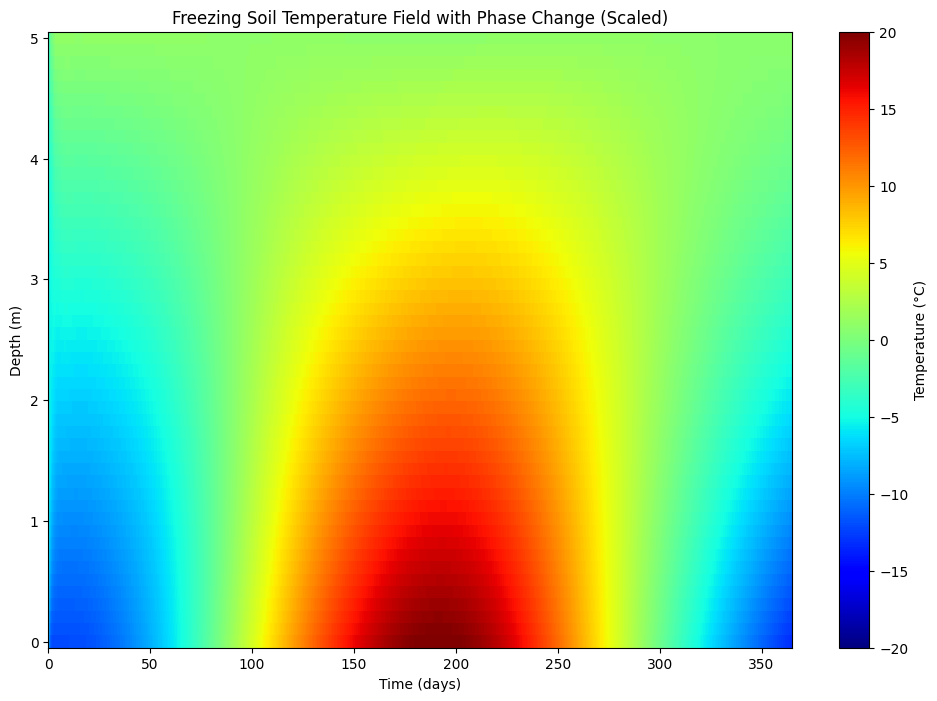

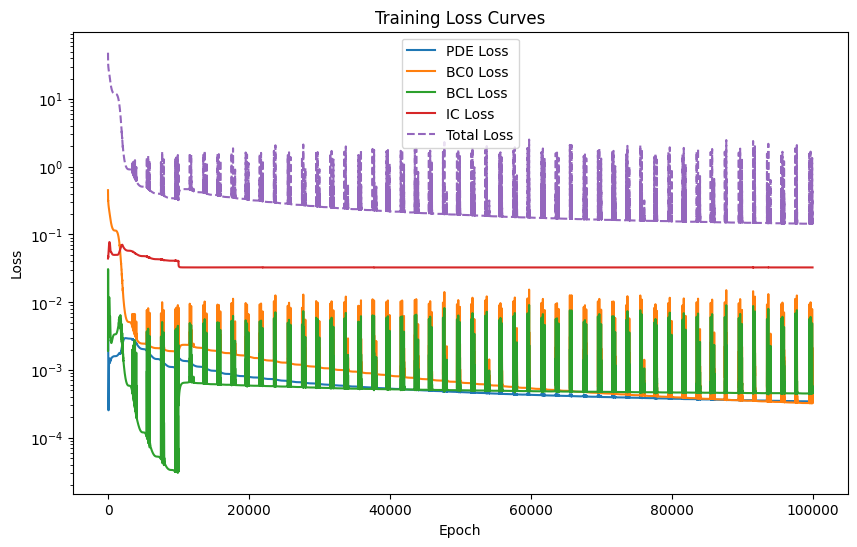

In [6]:
# Results visualization
def plot_results():
    x_test = torch.linspace(0, 5, 50, device=device).unsqueeze(1)
    t_test = torch.linspace(0, 365, 10000, device=device).unsqueeze(1)
    X, T = torch.meshgrid(x_test.squeeze(), t_test.squeeze())
    
    with torch.no_grad():
        inputs = torch.stack([X.ravel(), T.ravel()], dim=1)
        T_pred = pinn.predict(inputs[:,0:1], inputs[:,1:2]).cpu().numpy()
    
    # Scale back to the original range
    T_pred_scaled = T_pred * pinn.T_max
    
    plt.figure(figsize=(12,8))
    plt.pcolormesh(T.cpu().numpy(), X.cpu().numpy(), T_pred_scaled.reshape(50,10000), 
                   cmap='jet', shading='auto', vmin=-20, vmax=20)
    plt.colorbar(label='Temperature (°C)')
    plt.xlabel('Time (days)')
    plt.ylabel('Depth (m)')
    plt.title('Freezing Soil Temperature Field with Phase Change (Scaled)')
    
    # Add isotherms
    # levels = np.linspace(-20, 20, 15)
    # CS = plt.contour(T.cpu().numpy(), X.cpu().numpy(), T_pred_scaled.reshape(100,100), 
    #                 levels=levels, colors='k', linewidths=0.5)
    # plt.clabel(CS, inline=True, fontsize=8)
    
    plt.show()

plot_results()

# Plot loss curves
def plot_loss_curves():
    plt.figure(figsize=(10,6))
    plt.semilogy(pinn.pde_loss, label='PDE Loss')
    plt.semilogy(pinn.bc0_loss, label='BC0 Loss')
    plt.semilogy(pinn.bcL_loss, label='BCL Loss')
    plt.semilogy(pinn.ic_loss, label='IC Loss')
    plt.semilogy(pinn.loss_history, label='Total Loss', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training Loss Curves')
    plt.show()

plot_loss_curves()

Maximum absolute error: 6.4264 °C
Mean absolute error: 0.4681 °C
Maximum relative error: 5753307.61%
Mean relative error: 62.55%


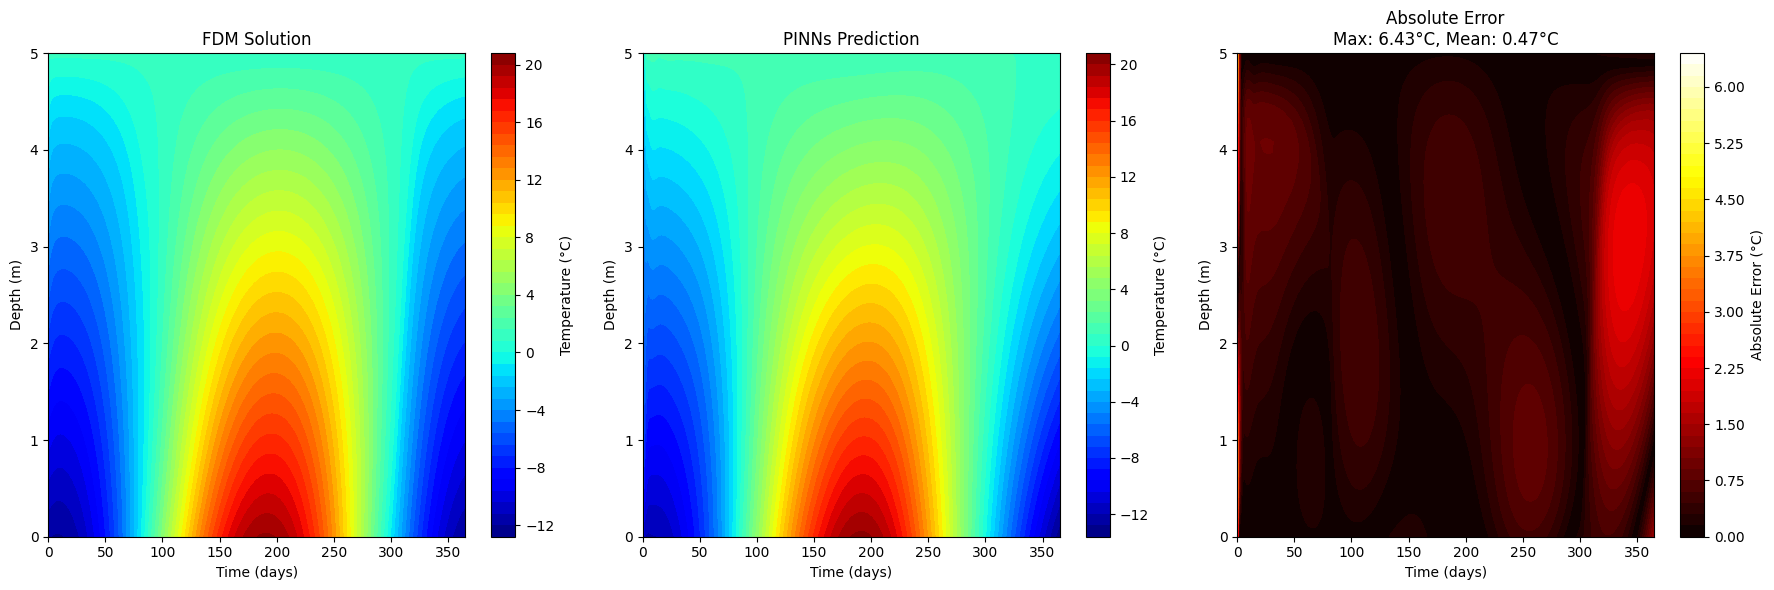

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# ===================================================
# FDM results
# ===================================================
# Assume the FDM results have already been computed
T_total = 365.0  # Total time (days)
Nx = 50          # Number of spatial points
Nt = 100000      # Number of time steps
Nx = 50  # Number of spatial points
Nt = 100000  # Number of time steps
Lx = 5.0  # Length of the domain (m) (from 0 m to 5.0 m)
x = np.linspace(0, Lx, Nx)  # Spatial grid from 0 m to 5.0 m
x_fdm = x  # Spatial grid (0 to 5 meters)
t_fdm = np.linspace(0, T_total, Nt)  # Time grid (0 to 365 days)
T_field = np.load('T_field.npy')          # Load again
T_field_fdm = T_field  # FDM computation result (array of shape Nx x Nt)

# ===================================================
# PINNs prediction
# ===================================================
# Assume the PINNs model has been trained and can predict temperature for any (x, t)
def pinn_predict(x, t):
    """PINNs prediction function, replace with your actual prediction code"""
    # Example code (to be replaced):
    inputs = torch.tensor(np.stack([x, t], axis=1), dtype=torch.float32).to(device)
    with torch.no_grad():
        return pinn.model(inputs).cpu().numpy().flatten()

# Predict on the FDM grid points
X_fdm, T_fdm = np.meshgrid(x_fdm, t_fdm)  # Generate grid points
T_field_pinn = np.zeros_like(T_field_fdm)  # Initialize PINNs prediction result

# Batch prediction (improves efficiency)
inputs = torch.tensor(np.stack([X_fdm.ravel(), T_fdm.ravel()], axis=1), dtype=torch.float32).to(device)
with torch.no_grad():
    T_field_pinn = pinn.model(inputs).cpu().numpy().reshape(X_fdm.shape).T * pinn.T_max  # Transpose to match FDM shape

# ===================================================
# Error analysis
# ===================================================
# Compute absolute and relative errors
abs_error = np.abs(T_field_pinn - T_field_fdm)
rel_error = abs_error / (np.abs(T_field_fdm) + 1e-6)  # Avoid division by zero

# Statistics
max_abs_error = np.max(abs_error)
mean_abs_error = np.mean(abs_error)
max_rel_error = np.max(rel_error)
mean_rel_error = np.mean(rel_error)

print(f"Maximum absolute error: {max_abs_error:.4f} °C")
print(f"Mean absolute error: {mean_abs_error:.4f} °C")
print(f"Maximum relative error: {max_rel_error*100:.2f}%")
print(f"Mean relative error: {mean_rel_error*100:.2f}%")

# ===================================================
# Visualization comparison
# ===================================================
plt.figure(figsize=(18, 6))

# FDM result
plt.subplot(1, 3, 1)
plt.contourf(t_fdm, x_fdm, T_field_fdm, levels=50, cmap='jet')
plt.colorbar(label='Temperature (°C)')
plt.xlabel('Time (days)')
plt.ylabel('Depth (m)')
plt.title('FDM Solution')

# PINNs result
plt.subplot(1, 3, 2)
plt.contourf(t_fdm, x_fdm, T_field_pinn, levels=50, cmap='jet')
plt.colorbar(label='Temperature (°C)')
plt.xlabel('Time (days)')
plt.ylabel('Depth (m)')
plt.title('PINNs Prediction')

# Absolute error
plt.subplot(1, 3, 3)
error_plot = plt.contourf(t_fdm, x_fdm, abs_error, levels=50, cmap='hot')
plt.colorbar(error_plot, label='Absolute Error (°C)')
plt.xlabel('Time (days)')
plt.ylabel('Depth (m)')
plt.title(f'Absolute Error\nMax: {max_abs_error:.2f}°C, Mean: {mean_abs_error:.2f}°C')

plt.tight_layout()
plt.show()


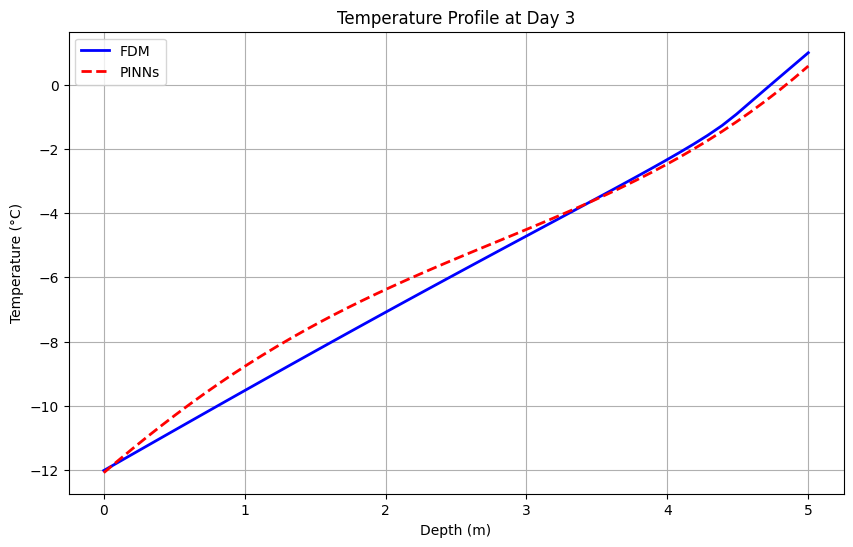

In [22]:
# ===================================================
# Time-slice comparison (example: Day 0)
# ===================================================
day = 3
t_index = int(day / T_total * Nt) - 1

plt.figure(figsize=(10, 6))
plt.plot(x_fdm, T_field_fdm[:, t_index], 'b-', linewidth=2, label='FDM')
plt.plot(x_fdm, T_field_pinn[:, t_index], 'r--', linewidth=2, label='PINNs')
plt.xlabel('Depth (m)')
plt.ylabel('Temperature (°C)')
plt.title(f'Temperature Profile at Day {day}')
plt.legend()
plt.grid(True)
plt.show()


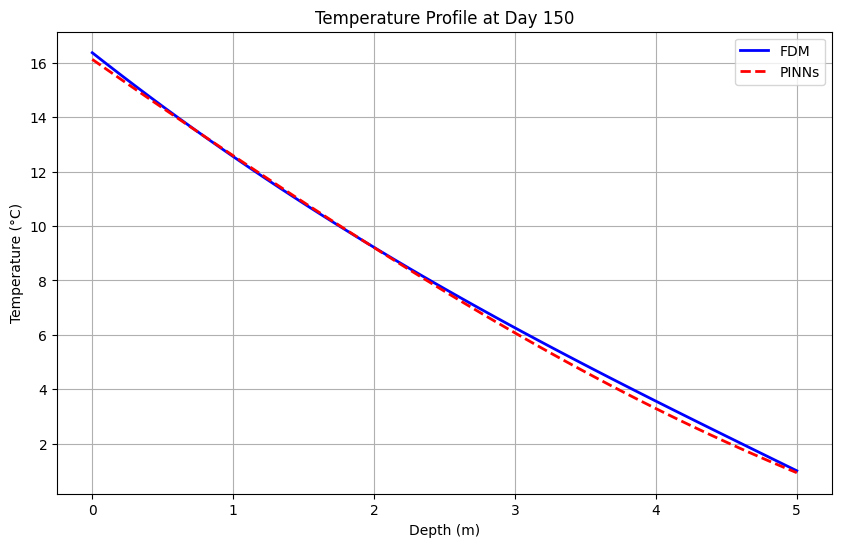

In [23]:
# ===================================================
# Time-slice comparison (example: Day 150)
# ===================================================
day = 150
t_index = int(day / T_total * Nt)

plt.figure(figsize=(10, 6))
plt.plot(x_fdm, T_field_fdm[:, t_index], 'b-', linewidth=2, label='FDM')
plt.plot(x_fdm, T_field_pinn[:, t_index], 'r--', linewidth=2, label='PINNs')
plt.xlabel('Depth (m)')
plt.ylabel('Temperature (°C)')
plt.title(f'Temperature Profile at Day {day}')
plt.legend()
plt.grid(True)
plt.show()

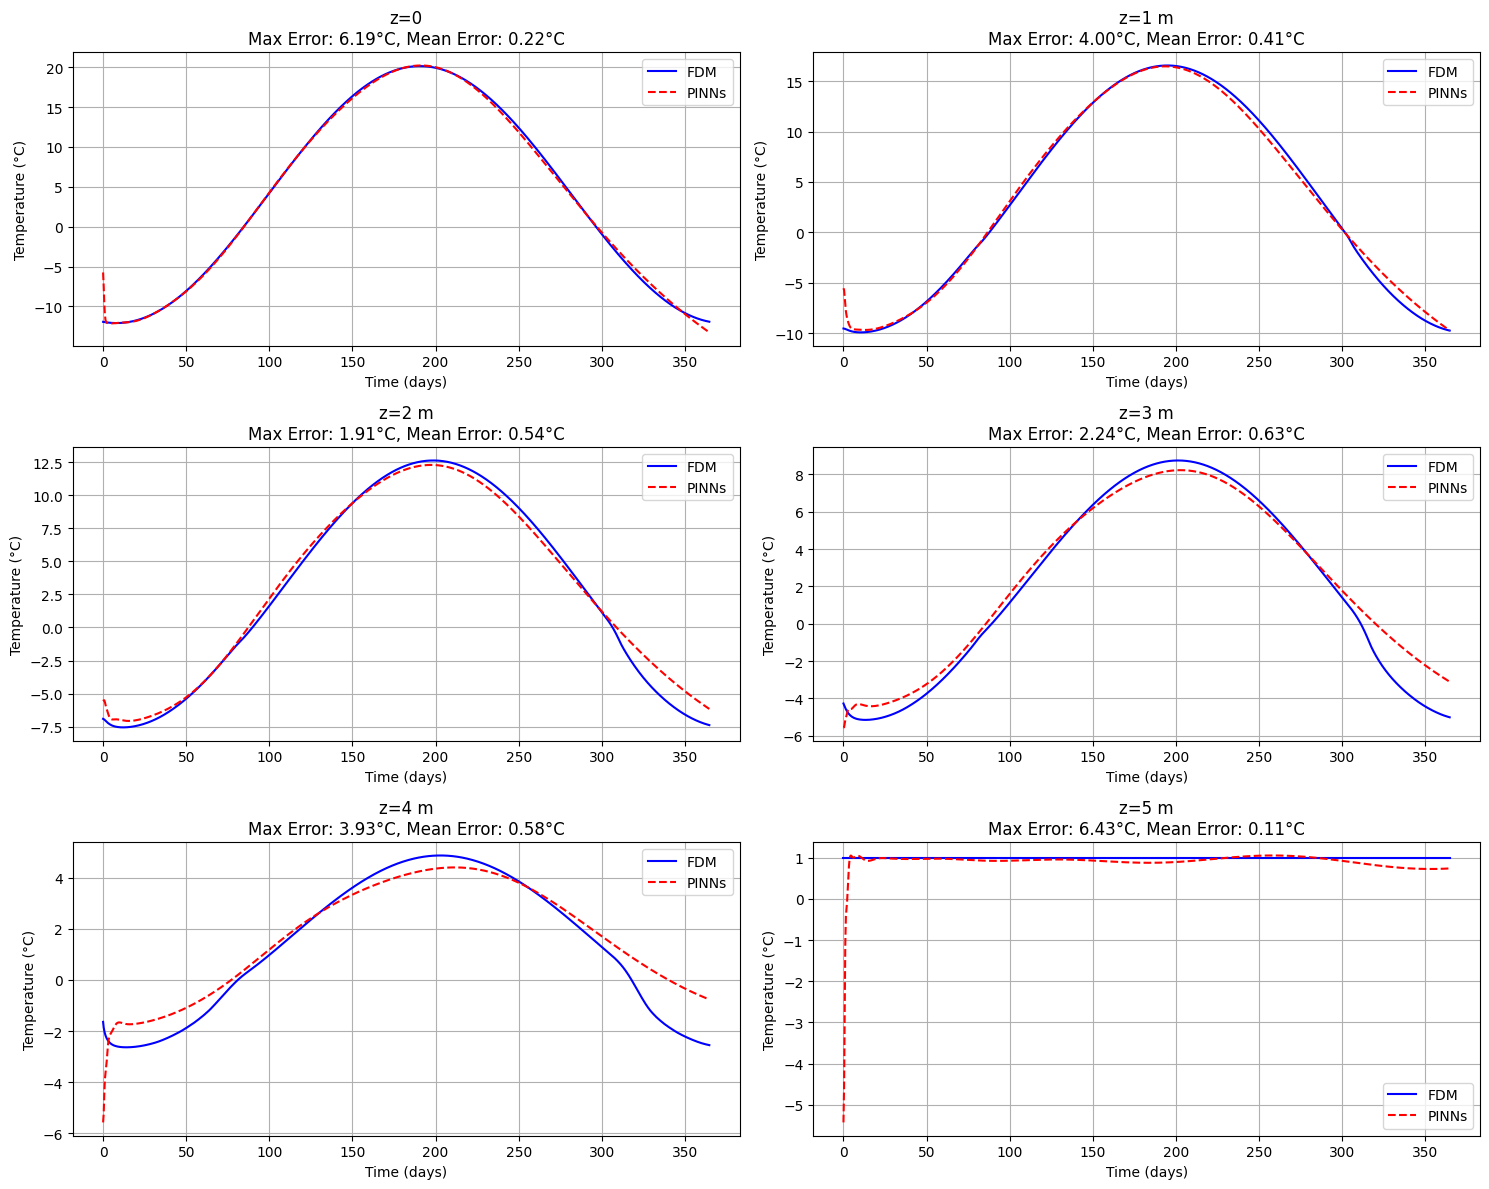

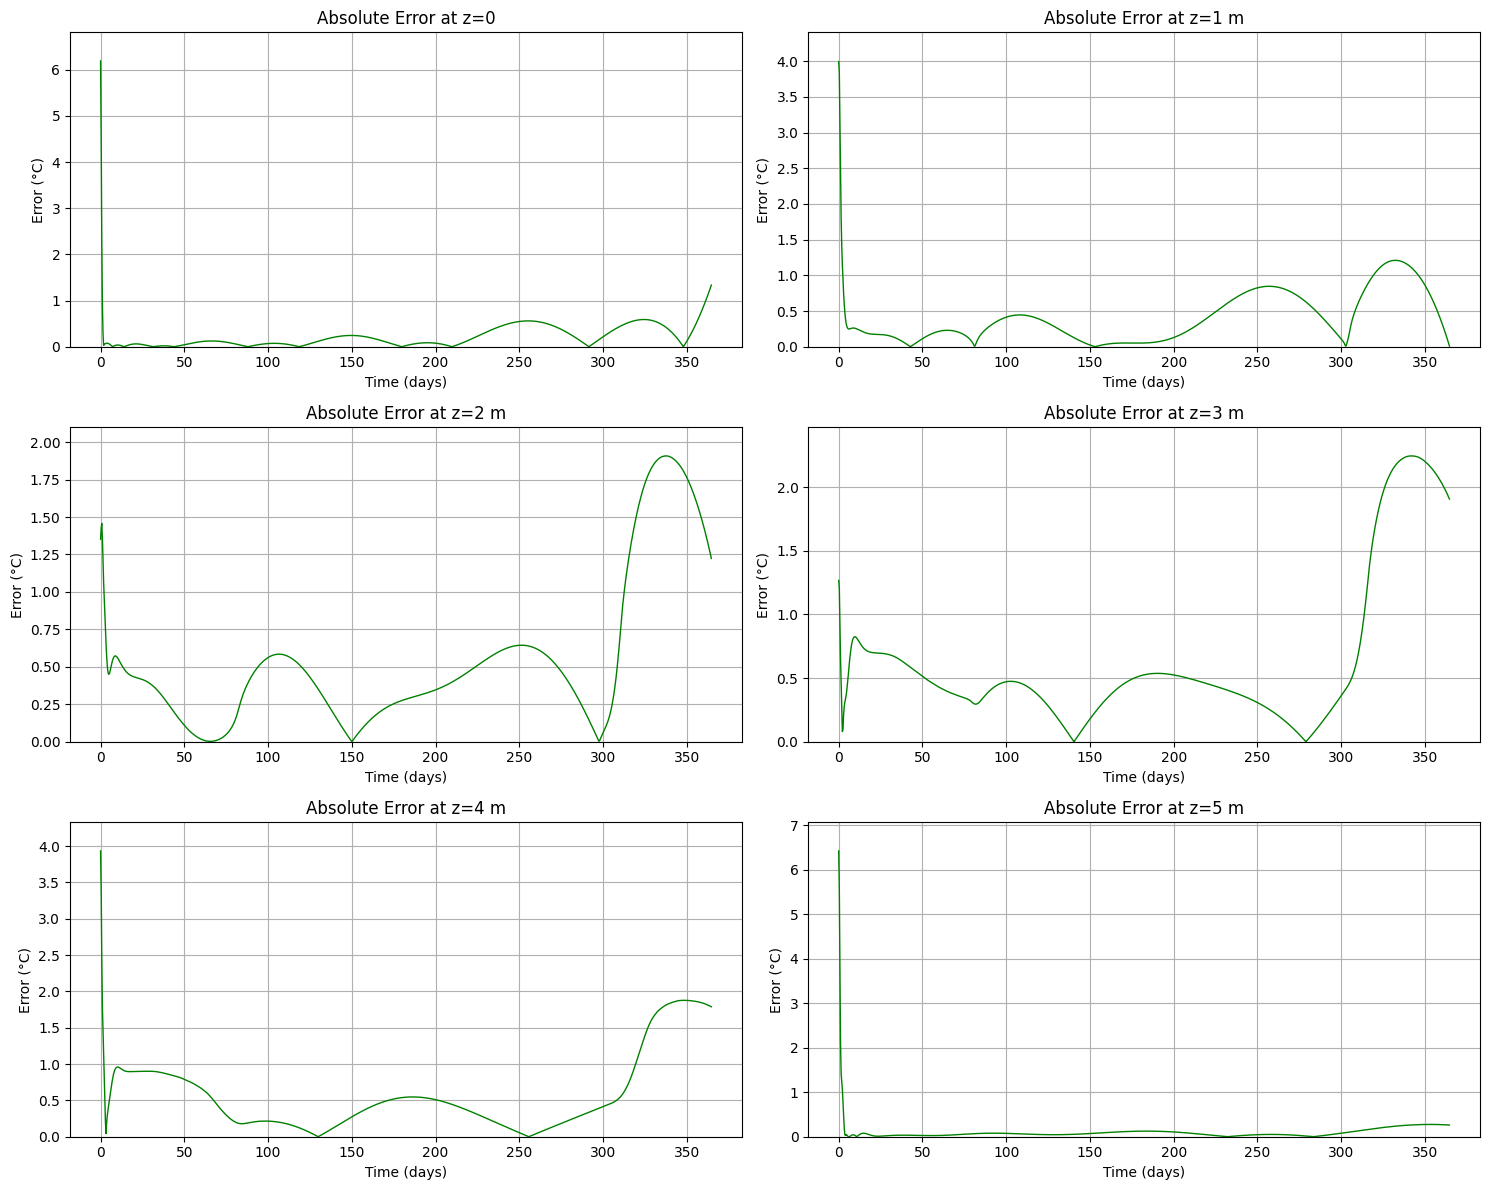

Depth | Max Absolute Error (°C) | Mean Absolute Error (°C)
z=0    | 6.1910                   | 0.2212                  
z=1 m  | 4.0047                   | 0.4066                  
z=2 m  | 1.9080                   | 0.5436                  
z=3 m  | 2.2445                   | 0.6280                  
z=4 m  | 3.9344                   | 0.5745                  
z=5 m  | 6.4264                   | 0.1037                  


In [24]:
import numpy as np
import matplotlib.pyplot as plt

# ===================================================
# Parameter settings
# ===================================================
depths = [0, 9, 19, 29, 39, 49]  # Indices corresponding to depths z=0,1,2,3,4,5 meters
depth_labels = ['z=0', 'z=1 m', 'z=2 m', 'z=3 m', 'z=4 m', 'z=5 m']

# ===================================================
# Load FDM results
# ===================================================


# ===================================================
# Visualization comparison
# ===================================================
plt.figure(figsize=(15, 12))

# Loop through each depth to plot comparisons
for idx, depth_idx in enumerate(depths):
    # Extract data
    t_plot = t_fdm[::100]  # Downsample: take one point every 100 steps
    fdm_vals = T_field_fdm[depth_idx, ::100]
    pinn_vals = T_field_pinn[depth_idx, ::100]
    
    # Create subplot
    plt.subplot(3, 2, idx+1)
    
    # Plot curves
    plt.plot(t_plot, fdm_vals, 'b-', linewidth=1.5, label='FDM')
    plt.plot(t_plot, pinn_vals, 'r--', linewidth=1.5, label='PINNs')
    
    # Compute errors
    abs_error = np.abs(pinn_vals - fdm_vals)
    max_error = np.max(abs_error)
    mean_error = np.mean(abs_error)
    
    # Add annotation
    plt.title(f'{depth_labels[idx]}\nMax Error: {max_error:.2f}°C, Mean Error: {mean_error:.2f}°C')
    plt.xlabel('Time (days)')
    plt.ylabel('Temperature (°C)')
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()

# ===================================================
# Error analysis (over the entire time domain)
# ===================================================
plt.figure(figsize=(15, 12))

for idx, depth_idx in enumerate(depths):
    # Compute absolute error
    abs_error = np.abs(T_field_pinn[depth_idx, :] - T_field_fdm[depth_idx, :])
    
    # Create subplot
    plt.subplot(3, 2, idx+1)
    
    # Plot error curve
    plt.plot(t_fdm[::100], abs_error[::100], 'g-', linewidth=1)
    plt.title(f'Absolute Error at {depth_labels[idx]}')
    plt.xlabel('Time (days)')
    plt.ylabel('Error (°C)')
    plt.grid(True)
    plt.ylim(0, np.max(abs_error)*1.1)

plt.tight_layout()
plt.show()

# ===================================================
# Statistical metrics output
# ===================================================
print("="*50)
print("Depth | Max Absolute Error (°C) | Mean Absolute Error (°C)")
print("="*50)
for idx, depth_idx in enumerate(depths):
    abs_error = np.abs(T_field_pinn[depth_idx, :] - T_field_fdm[depth_idx, :])
    print(f"{depth_labels[idx]:<6} | {np.max(abs_error):<24.4f} | {np.mean(abs_error):<24.4f}")
print("="*50)